In [1]:
import torch, os
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
import matplotlib.pyplot as plt
from tqdm import tqdm
from einops import rearrange, repeat
import copy
import numpy as np
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D


from torchvision.utils import save_image, make_grid
from torchvision import transforms
from torchvision.datasets import MNIST

from modules.networks.unet import UNetModel

os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Use only the first GPU
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

tf = transforms.Compose([transforms.ToTensor()]) # mnist is already normalised 0 to 1
train_dataset = MNIST("/data/edherron/data/MNIST", train=True, download=False, transform=tf)
# val_dataset = MNIST("/data/edherron/data/MNIST", train=False, download=False, transform=tf)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=256,
                                           shuffle=True,
                                           num_workers=1
                                           )

# val_loader = torch.utils.data.DataLoader(val_dataset, 
#                                         batch_size=256, 
#                                         shuffle=True, 
#                                         drop_last=True, 
#                                         num_workers=1
#                                         )

def pad(tensor):
    return repeat(tensor, 'b -> b 1 1 1')

In [2]:
class RectifiedFlow():
    def __init__(self, model=None, device=None, num_steps=1000):
        self.model = model
        self.model.to(device)
        self.N = num_steps
        self.device = device
        
    def get_train_tuple(self, z0=None, z1=None):
        t = torch.rand((z1.shape[0],)).to(self.device)
        z_t = pad(t) * z1 + (1. - pad(t)) * z0
        target = z1 - z0
        return z_t, t, target
    
    def rectified_flow_loss(self, batch, z0=None):
        z1 = batch.to(self.device)
        
        if z0 is None:
            z0 = torch.randn_like(batch).to(self.device)
        else:
            z0 = z0.to(self.device)
        
        z_t, t, target = self.get_train_tuple(z0, z1)
        
        pred = self.model(z_t, t)
        
        loss = F.mse_loss(pred, target)
        
        return loss
        
    @torch.no_grad()
    def sample_ode(self, z0=None, N=None, return_velocities=False):
        if N is None:
            N = self.N
        dt = 1./N
        trajectory = []
        velocities = []
        z = z0.detach().clone().to(self.device)
        
        
        trajectory.append(z.detach().clone())
        for i in range(N):
            t = torch.ones((z.shape[0],)) * i / N
            t = t.to(self.device)
            pred = self.model(z, t)
            z = z.detach().clone() + pred * dt
            trajectory.append(z.detach().clone())
            if return_velocities == True:
                velocities.append(pred.detach().clone())
        if return_velocities == True:
            return trajectory, velocities
        return trajectory

In [3]:
def train_rectified_flow(data_loader, rectified_flow, opt, device):
    rectified_flow.model.train()
    running_loss = 0.0
    for data in data_loader:
        z1, _ = data
        z1 = z1.to(device)
        # z1 = rearrange(z1.to(device), 'b c h w -> b (c h w)')
        z0 = torch.randn_like(z1).to(device)
        
        z_t, t, target = rectified_flow.get_train_tuple(z0, z1)
        
        pred = rectified_flow.model(z_t, t)
        
        loss = F.mse_loss(pred, target)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        running_loss += loss.item()
    avg_loss = running_loss / len(data_loader)
    return avg_loss

In [4]:
# Init all of our models
model = UNetModel()
RF = RectifiedFlow(model, device)

print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

opt = torch.optim.Adam(model.parameters(), lr=1e-4)

for i in tqdm(range(1)):
    loss_rec = train_rectified_flow(train_loader, RF, opt, device)
    print('loss from epoch ', i, ': ', loss_rec)
    
# torch.save(model.state_dict(), '/data/edherron/genmod/rectified_flow_weights/rf_1.pt')

Number of parameters:  3607873


  0%|          | 0/1 [00:00<?, ?it/s]

 xt  torch.Size([256, 1, 28, 28])
  t   torch.Size([256])
 x0  torch.Size([256, 1, 28, 28])
 xt  torch.Size([256, 1, 28, 28])
  t   torch.Size([256])
 x0  torch.Size([256, 1, 28, 28])
 xt  torch.Size([256, 1, 28, 28])
  t   torch.Size([256])
 x0  torch.Size([256, 1, 28, 28])
 xt  torch.Size([256, 1, 28, 28])
  t   torch.Size([256])
 x0  torch.Size([256, 1, 28, 28])
 xt  torch.Size([256, 1, 28, 28])
  t   torch.Size([256])
 x0  torch.Size([256, 1, 28, 28])
 xt  torch.Size([256, 1, 28, 28])
  t   torch.Size([256])
 x0  torch.Size([256, 1, 28, 28])
 xt  torch.Size([256, 1, 28, 28])
  t   torch.Size([256])
 x0  torch.Size([256, 1, 28, 28])
 xt  torch.Size([256, 1, 28, 28])
  t   torch.Size([256])
 x0  torch.Size([256, 1, 28, 28])
 xt  torch.Size([256, 1, 28, 28])
  t   torch.Size([256])
 x0  torch.Size([256, 1, 28, 28])
 xt  torch.Size([256, 1, 28, 28])
  t   torch.Size([256])
 x0  torch.Size([256, 1, 28, 28])
 xt  torch.Size([256, 1, 28, 28])
  t   torch.Size([256])
 x0  torch.Size([256, 

  0%|          | 0/1 [00:03<?, ?it/s]


KeyboardInterrupt: 

: 

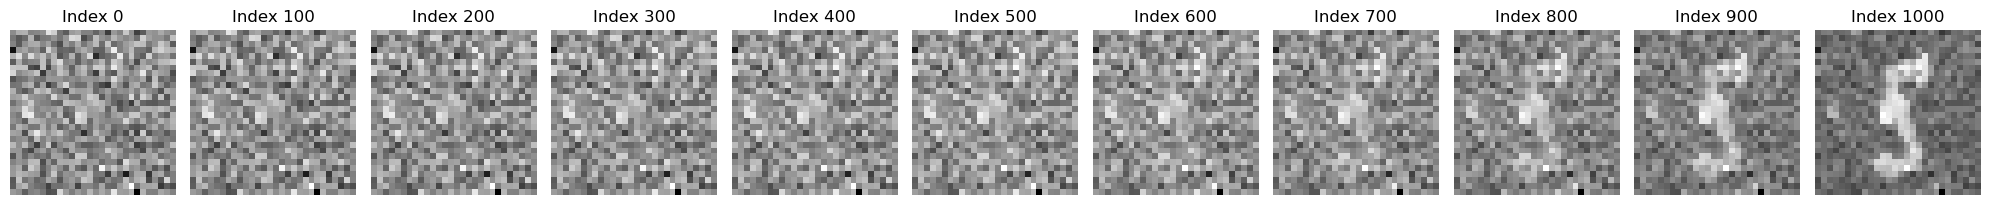

In [5]:
z = torch.randn((1,1,28,28))
trajectory = RF.sample_ode(z0 = z)

# Assuming `data_list` is your list of tensors
fig, axs = plt.subplots(1, 11, figsize=(20, 2))  # Adjust figsize as needed

for i, ax in enumerate(axs.flat):
    idx = i * 100  # Every 100th element
    if idx < len(trajectory):
        img = trajectory[idx].reshape(28, 28).detach().cpu().numpy()  # Reshape tensor to 28x28 for visualization
        ax.imshow(img, cmap='gray')  # Plot as grayscale image
        ax.set_title(f'Index {idx}')
        ax.axis('off')
    else:
        ax.axis('off')  # Hide axes for plots beyond the list length

plt.tight_layout()
plt.show()


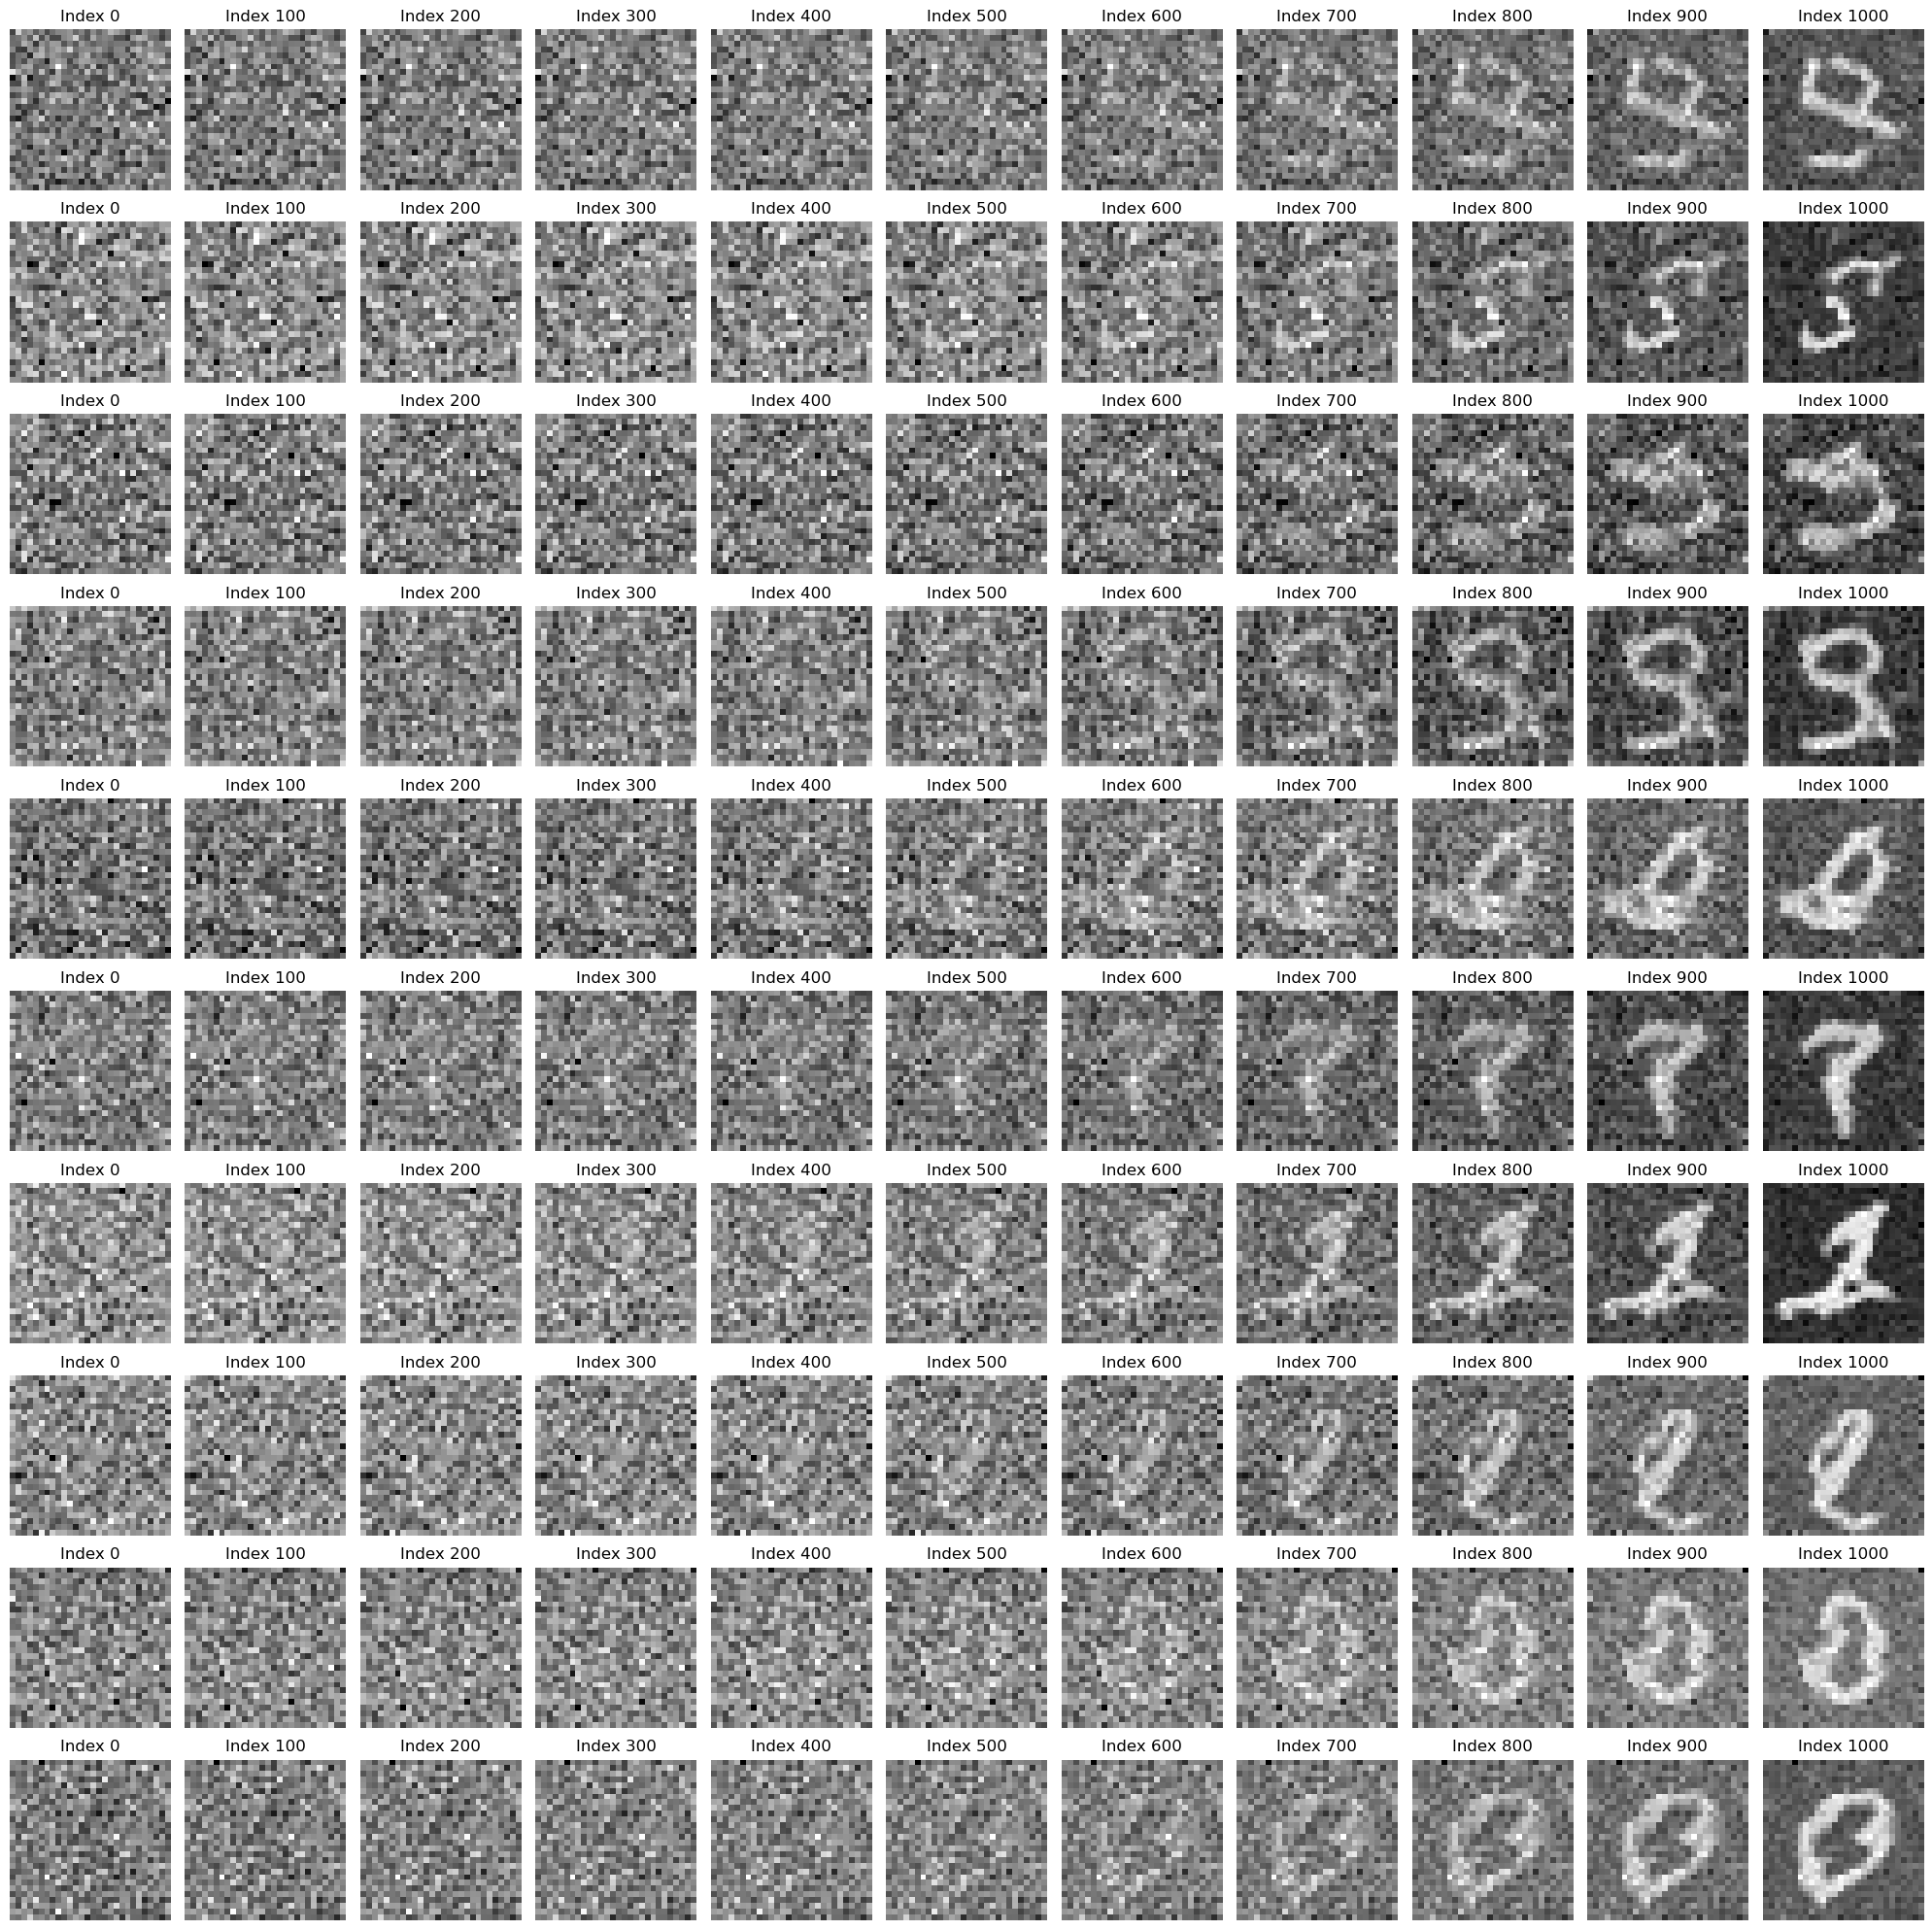

In [6]:
z = torch.randn((10, 1, 28, 28))
trajectories = [RF.sample_ode(z0=z[i].unsqueeze(0)) for i in range(10)]

# Set up the plot for 10 rows of trajectories, each with 11 time steps (same as the column convention)
fig, axs = plt.subplots(10, 11, figsize=(20, 20))  # Adjust figsize as needed, ensure there's enough space

for row, trajectory in enumerate(trajectories):
    for col, ax in enumerate(axs[row]):
        idx = col * 100  # Every 100th element as in the original convention
        if idx < len(trajectory):
            img = trajectory[idx].reshape(28, 28).detach().cpu().numpy()  # Reshape tensor to 28x28 for visualization
            ax.imshow(img, cmap='gray')  # Plot as grayscale image
            ax.set_title(f'Index {idx}')
            ax.axis('off')
        else:
            ax.axis('off')  # Hide axes for plots beyond the list length

plt.tight_layout()
plt.show()

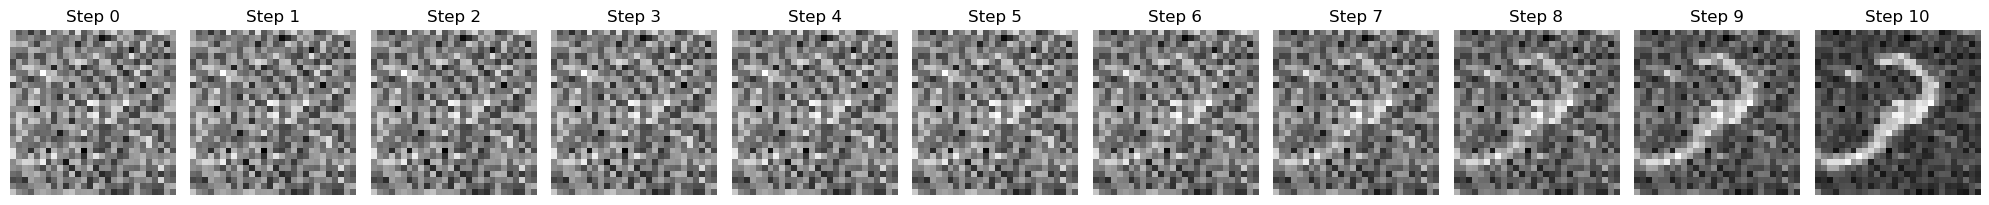

In [7]:
z = torch.randn((1, 1, 28, 28))
trajectory = RF.sample_ode(z0 = z, N = 10)  # This should give a trajectory with 11 tensors including the initial condition

# Assuming trajectory is your list of tensors with exactly 11 elements
fig, axs = plt.subplots(1, 11, figsize=(20, 2))  # Adjust figsize as needed

for idx, ax in enumerate(axs.flat):
    if idx < len(trajectory):
        img = trajectory[idx].reshape(28, 28).detach().cpu().numpy()  # Reshape tensor to 28x28 for visualization
        ax.imshow(img, cmap='gray')  # Plot as grayscale image
        ax.set_title(f'Step {idx}')
        ax.axis('off')
    else:
        ax.axis('off')  # Hide axes for plots beyond the list length

plt.tight_layout()
plt.show()

# Rectified Flow 2 model.
Here we take the pretrained RF model above and fine tune it on DETERMINISTIC pairs of z_0 and z_1. By randomly sampling z_0 and generating a new sample z_1 with the sampled z_0. 

In [8]:
z10 = []
z11 = []

for _ in range(100):  # The loop runs 10 times
    z = torch.randn((512, 1, 28, 28))  # Generate a new z of the specified size
    trajectory = RF.sample_ode(z0 = z, N = 10)  # Compute the trajectory

    # Assuming the trajectory output is a list of 11 tensors for each z in the batch
    z10.extend(trajectory[0])  # Extend z10 with the first tensors of each trajectory
    z11.extend(trajectory[-1])  # Extend z11 with the last tensors of each trajectory

# Check the lengths, should each be 10*512
print("Length of z10:", len(z10))
print("Length of z11:", len(z11))

z10_tensor = torch.stack(z10)  # Stack all tensors in z10 to create one tensor
z11_tensor = torch.stack(z11)  # Stack all tensors in z11 to create one tensor

print("z10 tensor shape:", z10_tensor.shape)
print("z11 tensor shape:", z11_tensor.shape)

z1_pairs = torch.stack([z10_tensor, z11_tensor], dim=1)
print("z1_pairs shape: ", z1_pairs.shape)

Length of z10: 51200
Length of z11: 51200
z10 tensor shape: torch.Size([51200, 1, 28, 28])
z11 tensor shape: torch.Size([51200, 1, 28, 28])
z1_pairs shape:  torch.Size([51200, 2, 1, 28, 28])


In [9]:
def train_rectified_flow_2(inner_iters, rectified_flow, opt, device):
    rectified_flow.model.train()
    running_loss = 0.0
    for _ in tqdm(range(inner_iters)):
        indices = torch.randperm(len(z10))[:256]
        batch = z1_pairs[indices]
        z0 = batch[:, 0].detach().clone()
        z1 = batch[:, 1].detach().clone()
        z0 = z0.to(device)
        z1 = z1.to(device)
        
        z_t, t, target = rectified_flow.get_train_tuple(z0, z1)
        
        pred = rectified_flow.model(z_t, t)
        
        loss = F.mse_loss(pred, target)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        running_loss += loss.item()
    avg_loss = running_loss / len(z10)
    return avg_loss

In [10]:
# Init all of our models
model_rf2 = UNetModel()
model_rf2.load_state_dict(torch.load('/data/edherron/genmod/rectified_flow_weights/rf_1.pt'))
RF_2 = RectifiedFlow(model=model_rf2, device=device, num_steps=100)
optimizer = torch.optim.Adam(RF_2.model.parameters(), lr=1e-4)

loss_rec = train_rectified_flow_2(50, RF_2, optimizer, device)
print('loss from epoch ', i, ': ', loss_rec)

# torch.save(model_rf2.state_dict(), '/data/edherron/genmod/rectified_flow_weights/rf_2.pt')

100%|██████████| 50/50 [00:06<00:00,  7.29it/s]

loss from epoch  10 :  1.639562959098839e-05


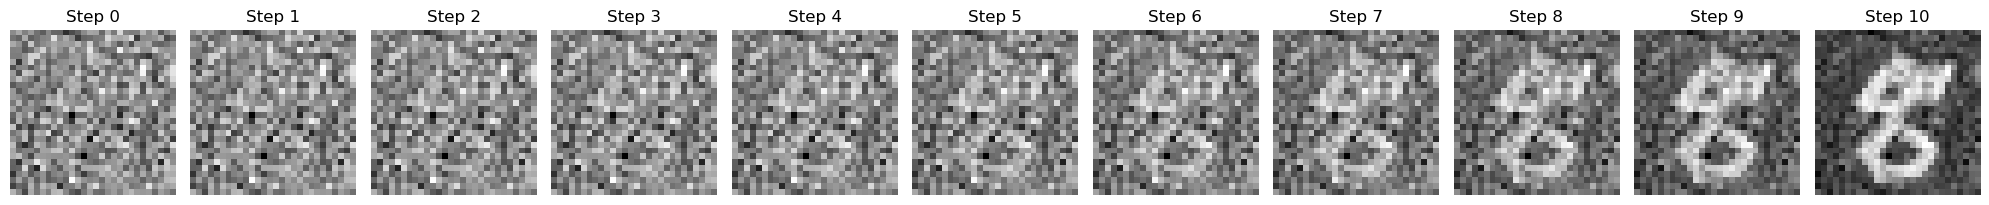

In [11]:
z = torch.randn((1, 1, 28, 28))
trajectory = RF_2.sample_ode(z0 = z, N = 10)  # This should give a trajectory with 11 tensors including the initial condition

# Assuming trajectory is your list of tensors with exactly 11 elements
fig, axs = plt.subplots(1, 11, figsize=(20, 2))  # Adjust figsize as needed

for idx, ax in enumerate(axs.flat):
    if idx < len(trajectory):
        img = trajectory[idx].reshape(28, 28).detach().cpu().numpy()  # Reshape tensor to 28x28 for visualization
        ax.imshow(img, cmap='gray')  # Plot as grayscale image
        ax.set_title(f'Step {idx}')
        ax.axis('off')
    else:
        ax.axis('off')  # Hide axes for plots beyond the list length

plt.tight_layout()
plt.show()

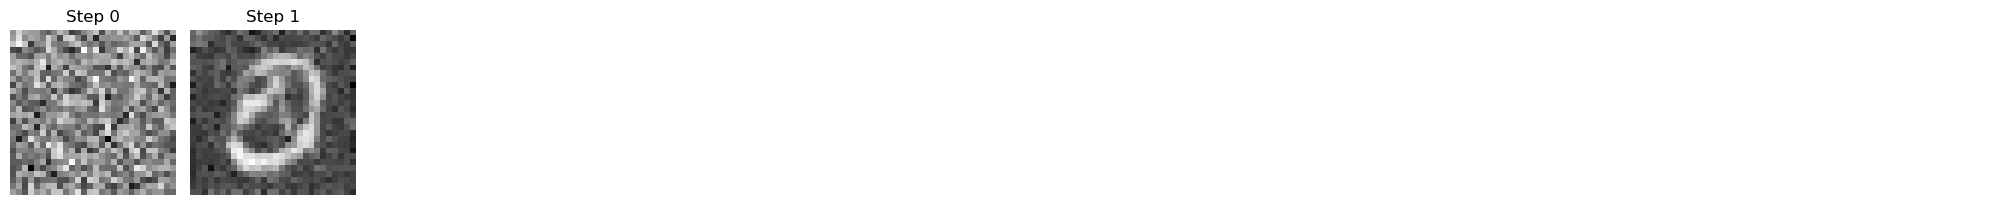

In [12]:
z = torch.randn((1, 1, 28, 28))
trajectory = RF_2.sample_ode(z0 = z, N = 1)  # This should give a trajectory with 11 tensors including the initial condition

# Assuming trajectory is your list of tensors with exactly 11 elements
fig, axs = plt.subplots(1, 11, figsize=(20, 2))  # Adjust figsize as needed

for idx, ax in enumerate(axs.flat):
    if idx < len(trajectory):
        img = trajectory[idx].reshape(28, 28).detach().cpu().numpy()  # Reshape tensor to 28x28 for visualization
        ax.imshow(img, cmap='gray')  # Plot as grayscale image
        ax.set_title(f'Step {idx}')
        ax.axis('off')
    else:
        ax.axis('off')  # Hide axes for plots beyond the list length

plt.tight_layout()
plt.show()

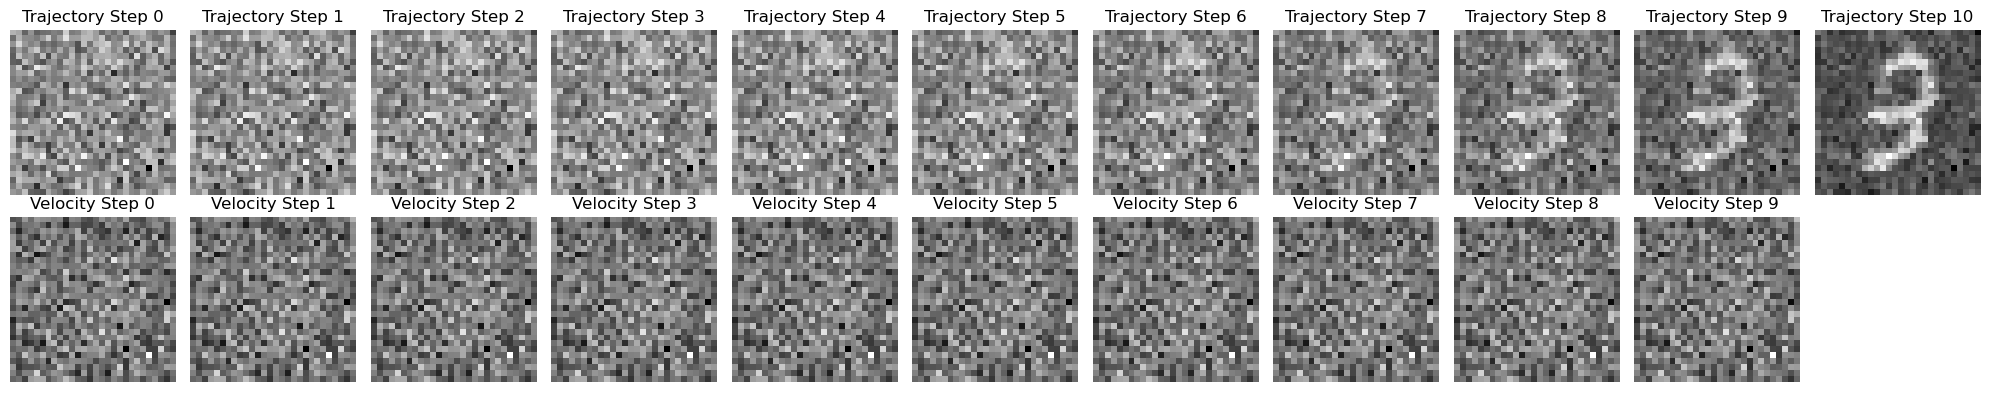

In [13]:
# plot out velocities as well as trajectory
z = torch.randn((1, 1, 28, 28))
trajectory, velocities = RF_2.sample_ode(z0 = z, N = 10, return_velocities=True)  # This should give a trajectory with 11 tensors including the initial condition

# Assuming trajectory and velocities are your lists of tensors
fig, axs = plt.subplots(2, len(trajectory), figsize=(20, 4))  # Adjust figsize as needed

for idx in range(len(trajectory)):
    # Plot trajectory tensors in the top row
    img = trajectory[idx].reshape(28, 28).detach().cpu().numpy()  # Reshape tensor to 28x28 for visualization
    axs[0, idx].imshow(img, cmap='gray')  # Plot as grayscale image
    axs[0, idx].set_title(f'Trajectory Step {idx}')
    axs[0, idx].axis('off')
    
    # Plot velocity tensors in the bottom row
    if idx < len(velocities):
        vel_img = velocities[idx].reshape(28, 28).detach().cpu().numpy()  # Reshape tensor to 28x28 for visualization
        axs[1, idx].imshow(vel_img, cmap='gray')  # Plot as grayscale image
        axs[1, idx].set_title(f'Velocity Step {idx}')
        axs[1, idx].axis('off')
    else:
        axs[1, idx].axis('off')  # Hide axes for plots without corresponding velocity tensor

plt.tight_layout()
plt.show()
